# 回顾神经网络的优化

欢迎来到本课程的第一个实验。这个练习的目标有三个：

- 复习神经网络训练的一些基本概念并为课堂建立通用词汇表。
- 说明神经网络训练中涉及的基本原理（特别是随机梯度下降）。
- 为本课程中的下一个实验奠定基础，最终引导我们实现在多个 GPU 上训练神经网络。

我们将从最简单的神经网络开始，即单个线性神经元：

<img src="https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_LinearNeuron.png" width="300" height="300"/>

我们将说明如何使用梯度下降和随机梯度下降算法训练该神经网络。

## 训练神经网络

### 生成随机数据集

在这个练习中，我们将训练一个神经网络来拟合一个随机生成的数据集，该数据集代表一条添加了随机噪声的直线。我们选择使用一个简单的神经网络来拟合这个数据集，虽然由于噪声，直线方程不能完全拟合数据，但它仍然是一个非常好的近似，允许我们深入研究神经网络的训练过程。

我们首先导入必要的 Python 库。 由于此练习刻意简单，因此这个列表很短：

In [54]:
# Numpy is a fundamental package for scientific computing. It contains an implementation of an array
# that we will use in this exercise.
import numpy as np
# We will be generating our own random dataset. As a consequence we need functionality to generate random numbers.
import random
# We will be plotting the progress of training using matplotlib, a package that can be used to generate 2D and 3D plots.
# We use the "widget" option to enable interactivity later on.
%matplotlib widget
import matplotlib.pyplot as plt
# We will use PyTorch as the deep learning framework of choice for this class.
import torch

In [55]:
# Define the number of samples/data points you want to generate
n_samples = 100
# We will define a dataset that lies on a line as defined by y = w_gen * x + b_gen
w_gen = 10
b_gen = 2
# To make the problem a bit more interesting we will add some Gaussian noise as 
# defined by the mean and standard deviation below.
mean_gen = 0
std_gen = 1

In [56]:
# This section generates the training dataset as defined by the variables in the section above.
x = np.float32(np.random.uniform(0, 10, [n_samples, 1]))
y = np.float32(np.array([w_gen * (x + np.random.normal(loc=mean_gen, scale=std_gen, size=None)) + b_gen for x in x]))

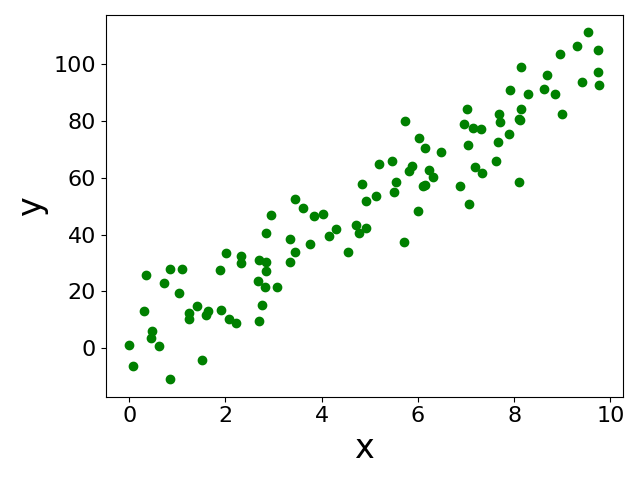

In [57]:
# Plot our randomly generated dataset
plt.close()
plt.plot(x, y, 'go')
plt.xlabel("x", size=24)
plt.ylabel("y", size=24)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

### 定义模型

无论机器学习的问题如何复杂，代码开发过程都包括：

- 创建模型的定义
- 定义将指导训练过程的损失（成本）函数。 损失函数实际上定义了训练是否成功，因为它为我们提供了有关优化算法在训练过程中取得的进展的信息。 </li>
- 然后迭代：
   - 计算损失函数相对于模型权重的梯度。
   - 更新模型权重（与梯度相反的方向）以最小化损失函数。

让我们为这个简单的模型实现上面的内容。 我们从模型的定义开始：

In [58]:
# Convert our inputs and outputs to Tensors. Storing our data as Tensors enables us to perform computations on the GPU. 
x = torch.from_numpy(x) if not torch.is_tensor(x) else x
y = torch.from_numpy(y) if not torch.is_tensor(y) else y

# To ensure that our code is device agnostic, we set our compute platform to be GPU based if one is available and CPU otherwise.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# There are several ways to implement our simple model. We are using PyTorch's built-in Linear module to initialize a model of the form y = w*x + b, 
# where w (weight) and b (bias) are the parameters to be learned. 
model = torch.nn.Linear(1, 1, bias = True, device = device)

# We will initialize w and b to be 0.
with torch.no_grad(): # diabling gradient calculation on weight and bias
    model.weight[0] = 0
    model.bias[0] = 0

### 定义损失函数

我们现在必须定义成功的含义。神经网络可以使用多种衡量成功的方法（损失函数）。有关您可以使用的损失函数范围的更多详细信息，以及如何做出此选择的详细说明，请参阅由伊恩·古德费洛 (Ian Goodfellow)、约书亚·本吉奥 (Yoshua Bengio) 和亚伦·库维尔 (Aaron Courville) 合著的<a href="http://www.deeplearningbook.org/">《深度学习》的第 6.2.1 节 </a>。

在我们的案例中，我们将使用成功的简单定义。即，我们将测量数据集中所有点与我们试图找到的直线之间的<b>距离</b>的平均值。

<img src="https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_CostFunction.png" width="350" height="350"/>

In [59]:
# We define the loss function which is an indicator of how good or bad our model is at any point of time.
loss_fn = torch.nn.MSELoss() #定义损失函数

### 定义优化逻辑：梯度下降

定义了模型和损失函数后，下一步是选择我们将使用的优化算法来找到最小化损失函数的参数 **w** 和 **b** 的组合（从而给我们最好的表现）。有多种优化算法可供选择（有关更详细的讨论，请参阅 [深度学习](http://www.deeplearningbook.org/contents/optimization.html) 的第 8 章）。在本练习中，我们将使用最基本的优化算法之一，**梯度下降法**。梯度下降法的运行机制如下图所示（为简单起见，未显示`b`）。请记住，由于大多数神经网络的损失函数都是非凸函数，算法最终可能会收敛在一个好的局部最小值而不是全局最小值上：

<img src='https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_GradientDescent.png'/>

在这个过程的每一步，模型都会使用模型参数的当前值（在我们的例子中是 w 和 b）遍历整个数据集并计算损失。然后计算损失函数的梯度（在这个简单的例子中，它是与曲线相切的直线的斜率）。一旦计算出梯度，它就可以用来慢慢地向最优解移动。

在实践中很少直接使用梯度下降（甚至下面讨论的随机梯度下降法）。相反，存在更有效的变体，允许算法更快地找到解决方案并在计算期间提供更好的稳定性。另请注意，梯度计算和优化逻辑必须从头开始编写的情况很少见。相反，所有重要的深度学习框架都提供自动微分以及多种优化算法。在我们的例子中，我们将选择框架提供的梯度下降的内置实现。

In [60]:
# 定义梯度下降优化器
# 请注意，“SGD”优化器是简单的梯度下降，如果梯度被用于
# 整个数据集；它是随机梯度下降， 如果它被用于
# 数据集的随机选取的子集
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### 循环训练

我们现在已经定义了数据集、模型、损失函数和优化算法，并准备开始训练（优化）过程。下面给出的循环将使用我们所有的训练数据来计算损失函数相对于模型参数的梯度。循环中调用的优化器将对模型参数做小的改动，使其越来越接近我们想要的解决方案（每一步改动的大小由我们之前定义的学习率决定）。我们将重复该过程足够多次，直至获得可以接受的解决方案。通常情况下，知道您已达到一个好的训练停止点的方法是损失函数已停止下降。

本练习的目的是了解优化过程的某些属性是如何依赖于梯度下降法的（特别是批量大小）。为了说明这一点，我们将在训练网络时记录损失函数的值，然后将其可视化。

我们要求您在下面的代码中完成一个小任务，即在下面单元格中由`FIXME`所指示的位置处补充代码（否则不会正常运行）。下面的代码块最多训练 1000 次，这比解决这个问题所需的要多得多。请在训练循环中补写代码，从而实现及早终止，即在训练收敛时就退出循环。收敛没有通用的定义，所以你必须选择一个适合这个问题的定义。一种可能的选择是，当损失函数在两个训练时期之间的变化小于 0.1% 时就停止训练（考虑前面几次训练的平均值）。您还可以选择考虑模型参数变化的速度。如果卡住了，您可以随时删除收敛检查并通过修改 `max_number_of_epochs` 来控制训练次数。

In [61]:
# The following line will reset model parameters so that the model is retrained from scratch every time,
# in case you need to re-run this cell during your work.
model.reset_parameters()

# Define the maximum number of times we want to process the entire dataset (the number of epochs).
# In practice we won't run this many because we'll implement an early stopping condition that
# detects when the training process has converged.
max_number_of_epochs = 1000  #定义最大的迭代次数。

# We will store information about the optimization process here. #定义输出
loss_array = []
b_array = []
w_array = []

# We will move our inputs and outputs to the GPU, where the model is also located.
inputs = x.to(device)
outputs = y.to(device)

# Print out the parameters and loss before we do any training
outputs_predicted = model(inputs)
loss_value = loss_fn(outputs_predicted, outputs)
print("Before training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(model.weight.item(), model.bias.item(), loss_value))

print("")
print("Starting training")
print("")

# Start the training process
for i in range(max_number_of_epochs):
    
    # Explicitly set gradients to zero before each forward pass to avoid gradient accumulation.
    optimizer.zero_grad()

    # Generate outputs for each example in our dataset and compute loss
    outputs_predicted = model(inputs)
    loss = loss_fn(outputs_predicted, outputs)

    # Compute gradient of the loss with respect to w and b
    loss.backward()

    # Update parameters
    optimizer.step()

    # Capture the data that we will use in our visualization
    w_array.append(model.weight.item())
    b_array.append(model.bias.item())
    loss_array.append(loss.item())

    if (i + 1) % 2 == 0:
        print("Epoch = {:2d}: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(i+1, model.weight.item(), model.bias.item(), loss.item()))

    # Implement your convergence check here, and exit the training loop if
    # you detect that we are converged:
    if i > 1 and abs(loss_array[i] - loss_array[i-1]) / loss_array[i-1] < 0.001:
        break

print("")
print("Training finished after {} epochs".format(i+1))
print("")

print("After training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(model.weight.item(), model.bias.item(), loss.item()))

Before training: w = 0.457, b = -0.944, loss = 3194.149

Starting training

Epoch =  2: w = 1.664, b = -0.756, loss = 2808.339
Epoch =  4: w = 2.721, b = -0.591, loss = 2174.976
Epoch =  6: w = 3.647, b = -0.447, loss = 1689.645
Epoch =  8: w = 4.456, b = -0.320, loss = 1317.749
Epoch = 10: w = 5.165, b = -0.210, loss = 1032.774
Epoch = 12: w = 5.786, b = -0.112, loss = 814.404
Epoch = 14: w = 6.329, b = -0.027, loss = 647.073
Epoch = 16: w = 6.805, b = 0.047, loss = 518.852
Epoch = 18: w = 7.221, b = 0.112, loss = 420.599
Epoch = 20: w = 7.586, b = 0.170, loss = 345.310
Epoch = 22: w = 7.904, b = 0.220, loss = 287.618
Epoch = 24: w = 8.184, b = 0.264, loss = 243.410
Epoch = 26: w = 8.428, b = 0.302, loss = 209.534
Epoch = 28: w = 8.642, b = 0.336, loss = 183.576
Epoch = 30: w = 8.829, b = 0.366, loss = 163.685
Epoch = 32: w = 8.993, b = 0.392, loss = 148.443
Epoch = 34: w = 9.137, b = 0.415, loss = 136.764
Epoch = 36: w = 9.262, b = 0.435, loss = 127.814
Epoch = 38: w = 9.372, b = 0.4

如果您在上面的练习中遇到困难，请显示下面的单元格（通过单击三个点）以查看收敛检查的示例。

<font face="courier">
<pre>
            # Example solution for the convergence check<br />
            if i > 1 and abs(loss_array[i] - loss_array[i-1]) / loss_array[i-1] < 0.001:<br />
</pre>
</font>

从下面列出的输出中，我们可以看到我们已经设法将损失降到最低，并设法获得了一个足够接近希望得到的函数的解决方案（将 w 和 b 的当前值与目标值 w_gen 和 b_gen 进行比较）。现在让我们将损失绘制为时间（完成的次数）的函数。该图是监视训练过程进度的基础，可帮助我们了解如何做出与模型或数据集改进有关的决策。

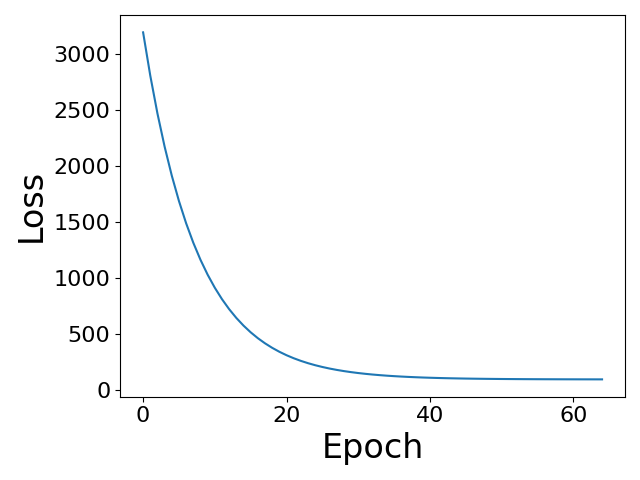

In [62]:
plt.close()
plt.plot(loss_array)
plt.xlabel("Epoch", size=24)
plt.ylabel("Loss", size=24)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

### 研究损失函数的进度

由于在我们的例子中，损失函数仅取决于两个参数（w 和 b），因此可以直接可视化其形状。此外，优化算法在此损失函数空间中采用的轨迹也可以进行可视化，下图说明了这一点（请注意，该图是交互式的，您可以旋转它）：

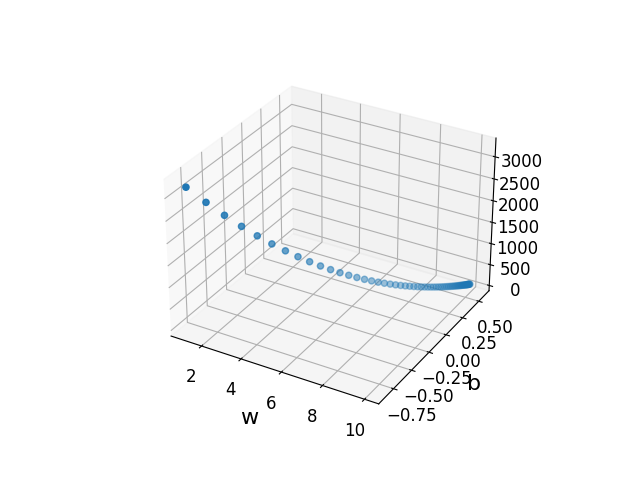

In [63]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(w_array, b_array, loss_array)

ax.set_xlabel('w', size=16)
ax.set_ylabel('b', size=16)
ax.tick_params(labelsize=12)

plt.show()

现在让我们通过在该区域中绘制整个损失函数来扩展我们的可视化。 由于整个数据集用于损失函数的计算，我们只获得一个曲面，并且我们的优化器采用的轨迹相当平滑，几乎没有噪音。当我们开始使用数据子集来计算随机梯度下降时，情况就不会是这样了。

In [64]:
loss_surface = []
w_surface = []
b_surface = []

for w_value in np.linspace(0, 20, 200):
    for b_value in np.linspace(-18, 22, 200):
        
        # Collect information about the loss function surface
        with torch.no_grad():
            model.weight[0] = w_value
            model.bias[0] = b_value

        outputs_predicted = model(inputs)
        loss = loss_fn(outputs_predicted, outputs)
        
        b_surface.append(b_value)
        w_surface.append(w_value)
        loss_surface.append(loss.item())

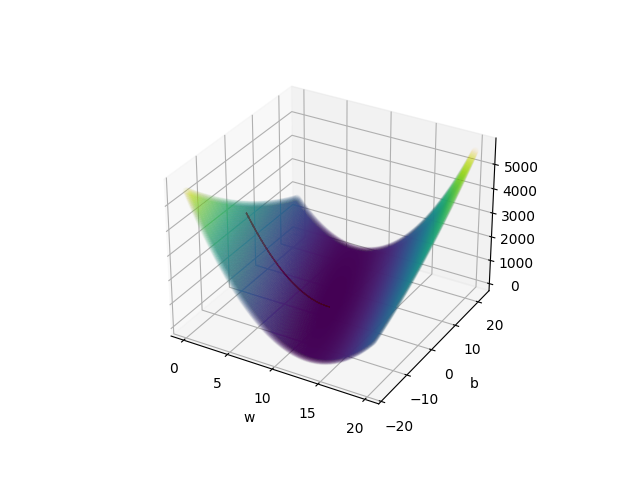

In [65]:
plt.close()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')

ax2.scatter(w_surface, b_surface, loss_surface, c = loss_surface, alpha = 0.02)
ax2.plot(w_array, b_array, loss_array, color='red')

ax2.set_xlabel('w')
ax2.set_ylabel('b')

plt.show()

# 随机梯度下降

与梯度下降不同的是，随机梯度下降不使用整个数据集来计算损失函数的形状。相反，它使用较小的数据子集。这对我们算法的行为具有深远的影响。由于每个批次都是不同的，即使对于同一组权重，单个批次的计算损失也会与整个数据集的不同。由于按批次的损失函数不同，损失函数的梯度也会不同，这会引入一定程度的噪声。

>注意：形式上，**随机**梯度下降表示使用批量大小为1，**批量**梯度下降表示将整个数据集用作单个批量，**小批量**梯度下降表示批量大小介于 **随机** 和 **批量h** 梯度下降之间。也就是说，按照通常的说法，我们通常不会区分 **随机** 和 **小批量** 梯度下降，而是使用术语 **随机** 梯度下降来表示小于整个数据集的任何批量大小的情况。

让我们考虑一下随机梯度下降如何应用于我们的这个简单的模型。粗绿线说明了给定所有数据的损失函数的形状。细绿线是单个批次（有时称为小批量）的损失函数的形状。由于这些曲线不同，梯度的估计在每一步都会不同。这可以看作是在优化过程中添加了噪声元素。

#### Step 1

![](./images/SGD1.png)

#### Step 2

![](./images/SGD2.png)

#### Step 3

![](./images/SGD3.png)

通过在此过程中添加噪声元素（批量越小，噪声越大），我们可以降低陷入局部最小值的可能性并增加定位全局最小值的机会。稍后我们将研究这在现实神经网络模型的背景下是如何发挥作用的。

## 实现随机梯度下降：第一种方法

为了演示这种现象，让我们对代码做一些小改动。我们不会在每次迭代中向模型提供所有的数据样本，而是只提供一个样本（批量大小为 1），以放大效果。

In [66]:
# The following line will reset model parameters so that the model is retrained from scratch every time,
# in case you need to re-run this cell during your work.
model.reset_parameters()

# Define the maximum number of times we want to process the entire dataset (the number of epochs).
# In practice we won't run this many because we'll implement an early stopping condition that
# detects when the training process has converged.
max_number_of_epochs = 1000

# We will store information about the optimization process here.
loss_array = []
b_array = []
w_array = []

# Zero out the initial values
with torch.no_grad():
    model.weight[0] = 0
    model.bias[0] = 0
    
# Print out the parameters and loss before we do any training
outputs_predicted = model(inputs)
loss_value = loss_fn(outputs_predicted, outputs)
print("Before training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(model.weight.item(), model.bias.item(), loss_value))

print("")
print("Starting training")
print("")

# Start the training process
for i in range(max_number_of_epochs):
    
    # Update after every data point
    for (x_pt, y_pt) in zip(inputs, outputs):

        optimizer.zero_grad()

        y_pt_predicted = model(x_pt)

        loss = loss_fn(y_pt_predicted, y_pt)

        loss.backward()

        optimizer.step()
        
        # Capture the data that we will use in our visualization
        # Note that we are now updating our loss function after
        # every point in the sample, so the size of loss_array
        # will be greater by a factor of n_samples compared to
        # the last exercise.
        w_array.append(model.weight.item())
        b_array.append(model.bias.item())
        loss_array.append(loss.item())

    # At the end of every epoch after the first, print out the learned weights
    if i > 0:
        avg_w = sum(w_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
        avg_b = sum(b_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
        avg_loss = sum(loss_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
        print("Epoch = {:2d}: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(i+1, avg_w, avg_b, avg_loss))

    # End the training when the loss function has not changed from the last epoch
    # by more than a small amount. Note that in our convergence check we will compare
    # the loss averaged over this epoch with the loss averaged over the last epoch.
    if i > 1:
        average_loss_this_epoch = sum(loss_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
        average_loss_last_epoch = sum(loss_array[(i-2)*n_samples:(i-1)*n_samples]) / n_samples
        if abs(average_loss_this_epoch - average_loss_last_epoch) / average_loss_last_epoch < 0.001:
            break

print("")
print("Training finished after {} epochs".format(i+1))
print("")

avg_w = sum(w_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
avg_b = sum(b_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
avg_loss = sum(loss_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples

print("After training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(avg_w, avg_b, avg_loss))

Before training: w = 0.000, b = 0.000, loss = 3390.490

Starting training

Epoch =  2: w = 8.479, b = 1.333, loss = 378.504
Epoch =  3: w = 9.980, b = 1.552, loss = 103.614
Epoch =  4: w = 9.984, b = 1.537, loss = 103.598

Training finished after 4 epochs

After training: w = 9.984, b = 1.537, loss = 103.598


将最终的损失与我们之前获得的损失进行比较，并且比较前后两次的权重参数。您可能没有得到相同的总损失值 —— 以前的答案更准确吗？

让我们绘制随时间变化的损失。我们可以做出的一个选择是在每次更新权重参数后绘制损失。这可能会是一个明显更嘈杂的曲线，因为我们没有对整个数据集的更新进行平均。

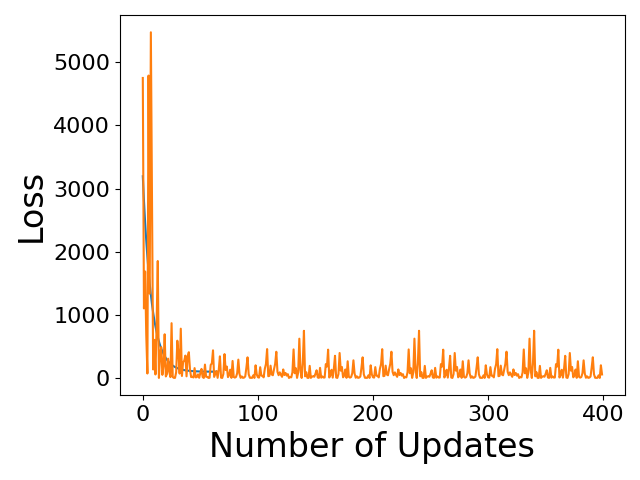

In [67]:
plt.close()
plt.plot(loss_array)
plt.xlabel("Number of Updates", size=24)
plt.ylabel("Loss", size=24)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

通过绘制优化器在损失函数空间中采用的轨迹，我们可以看到类似的效果。

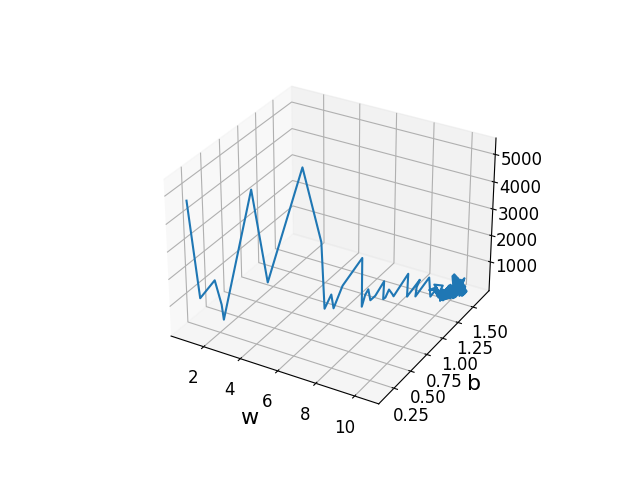

In [68]:
from mpl_toolkits.mplot3d import Axes3D

plt.close()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(w_array, b_array, loss_array)

ax.set_xlabel('w', size=16)
ax.set_ylabel('b', size=16)
ax.tick_params(labelsize=12)

plt.show()

<div>绘制其中一个小批量的损失曲面，我们清楚地看到，它不再与一次生成一个小批量的优化轨迹对齐了（并且对于每个小批量，损失曲面确实不同）。</div>

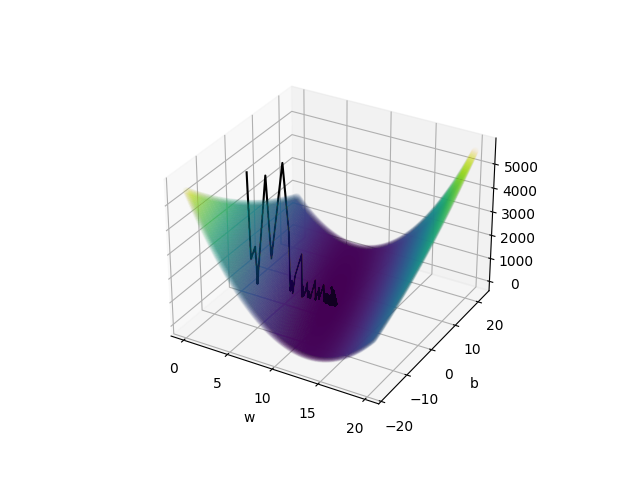

In [69]:
plt.close()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')

ax2.scatter(w_surface, b_surface, loss_surface, c = loss_surface, alpha = 0.02)
ax2.plot(w_array, b_array, loss_array, color='black')

ax2.set_xlabel('w')
ax2.set_ylabel('b')

plt.show()

## 用这个简单的模型试验各种批量大小

我们已经比较了两个极端情况：批量大小为完整数据集的梯度下降（即传统的梯度下降）和批量大小为 1 的 SGD。现在让我们尝试在中间的一些批量大小。 为此，请使用下面的单元格修改我们上面使用的代码，以在每个步骤中传递要训练的数据子集。

您需要做的就是按顺序遍历数据集，将批量大小为 M 的每个连续块传递给优化器。在理想情况下，您的实现应该适用于任何数字 M，其中 1 <= M <= N，此处 N 是数据集中的总样本数。数据集通常不会被批次的大小所整除，因此请确保仅使用所有剩余的数据项来作为数据集中的最后一批（因此它将是一个较小的批次）。

下面的单元格中有 3 个`FIXME`语句来指示您应完成的工作。如果遇到困难，下面还有一个解决方案供您参考。

In [71]:
# 以下行将重置模型参数，以便每次都从头开始重新训练模型，
# 以防你在工作期间需要重新运行这个单元格。
model.reset_parameters()

# Define the maximum number of times we want to process the entire dataset (the number of epochs).
# In practice we won't run this many because we'll implement an early stopping condition that
# detects when the training process has converged.
max_number_of_epochs = 1000

# We will store information about the optimization process here.
loss_array = []
b_array = []
w_array = []

# Zero out the initial values
with torch.no_grad():
    model.weight[0] = 0
    model.bias[0] = 0
    
# Print out the parameters and loss before we do any training
outputs_predicted = model(inputs)
loss_value = loss_fn(outputs_predicted, outputs)
print("Before training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(model.weight.item(), model.bias.item(), loss_value))

print("")
print("Starting training")
print("")

# Pass in batches of the dataset
# After the first run, try batch sizes of 16, 64, and 128
batch_size = 64
num_batches_in_epoch = (n_samples + batch_size - 1) // batch_size

# Start the training process
for i in range(max_number_of_epochs):

    for j in range(num_batches_in_epoch):
        batch_start = j * batch_size
        batch_end = min((j + 1) * batch_size, n_samples)

        optimizer.zero_grad()

        outputs_predicted = model(inputs[batch_start:batch_end])

        loss = loss_fn(outputs_predicted, outputs[batch_start:batch_end])

        loss.backward()

        optimizer.step()

        w_array.append(model.weight.item())
        b_array.append(model.bias.item())
        loss_array.append(loss.item())

    # At the end of every epoch after the first, print out the learned weights
    if i > 0:
        avg_w = sum(w_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
        avg_b = sum(b_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
        avg_loss = sum(loss_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
        print("Epoch = {:2d}: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(i+1, avg_w, avg_b, avg_loss))

    # End the training when the loss function has not changed from the last epoch
    # by more than a small amount. Note that in our convergence check we will compare
    # the loss averaged over this epoch with the loss averaged over the last epoch.
    if i > 1:
        average_loss_this_epoch = sum(loss_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
        average_loss_last_epoch = sum(loss_array[(i-2)*num_batches_in_epoch:(i-1)*num_batches_in_epoch]) / num_batches_in_epoch
        if abs(average_loss_this_epoch - average_loss_last_epoch) / average_loss_last_epoch < 0.001:
            break

print("")
print("Training finished after {} epochs".format(i+1))
print("")

avg_w = sum(w_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
avg_b = sum(b_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
avg_loss = sum(loss_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch

print("After training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(avg_w, avg_b, avg_loss))

Before training: w = 0.000, b = 0.000, loss = 3390.490

Starting training

Epoch =  2: w = 0.945, b = 0.147, loss = 3153.383
Epoch =  3: w = 2.067, b = 0.321, loss = 2438.732
Epoch =  4: w = 3.049, b = 0.474, loss = 1891.140
Epoch =  5: w = 3.909, b = 0.607, loss = 1471.550
Epoch =  6: w = 4.661, b = 0.724, loss = 1150.036
Epoch =  7: w = 5.319, b = 0.827, loss = 903.669
Epoch =  8: w = 5.896, b = 0.917, loss = 714.881
Epoch =  9: w = 6.400, b = 0.995, loss = 570.212
Epoch = 10: w = 6.842, b = 1.064, loss = 459.348
Epoch = 11: w = 7.229, b = 1.125, loss = 374.388
Epoch = 12: w = 7.567, b = 1.178, loss = 309.276
Epoch = 13: w = 7.863, b = 1.224, loss = 259.375
Epoch = 14: w = 8.122, b = 1.265, loss = 221.128
Epoch = 15: w = 8.349, b = 1.300, loss = 191.812
Epoch = 16: w = 8.548, b = 1.332, loss = 169.341
Epoch = 17: w = 8.721, b = 1.359, loss = 152.115
Epoch = 18: w = 8.874, b = 1.383, loss = 138.909
Epoch = 19: w = 9.007, b = 1.404, loss = 128.784
Epoch = 20: w = 9.123, b = 1.423, loss

如果您在上述练习中遇到困难，请显示下面的单元格以查看示例解决方案。

<font face="courier">
<pre>

num_batches_in_epoch = (n_samples + batch_size - 1) // batch_size
    
...

    for j in range(num_batches_in_epoch):
        batch_start = j * batch_size
        batch_end = min((j + 1) * batch_size, n_samples)

</pre>
</font>

现在对于您尝试过的每个批次大小，重复绘图过程以查看结果如何。请注意哪个批量大小产生了最佳的最终精度，不过要特别注意作为训练次数的函数的精度曲线的平滑度，并思考该平滑度如何依赖于批量大小。

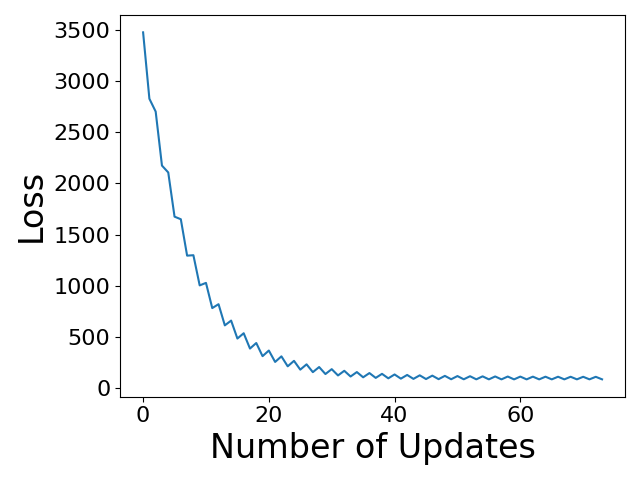

In [72]:
plt.close()
plt.plot(loss_array)
plt.xlabel("Number of Updates", size=24)
plt.ylabel("Loss", size=24)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

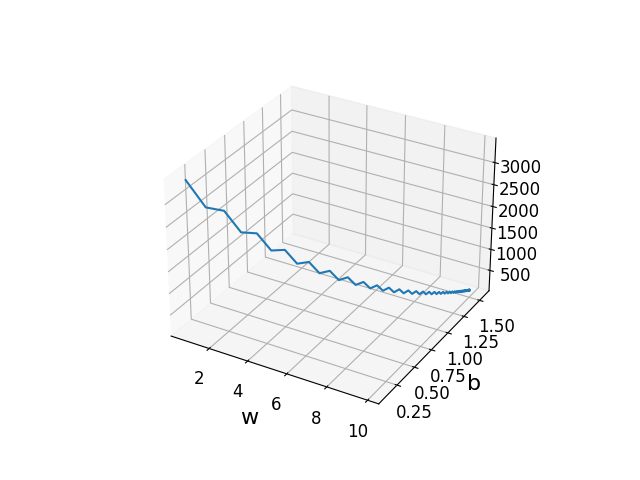

In [73]:
from mpl_toolkits.mplot3d import Axes3D

plt.close()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(w_array, b_array, loss_array)

ax.set_xlabel('w', size=16)
ax.set_ylabel('b', size=16)
ax.tick_params(labelsize=12)

plt.show()

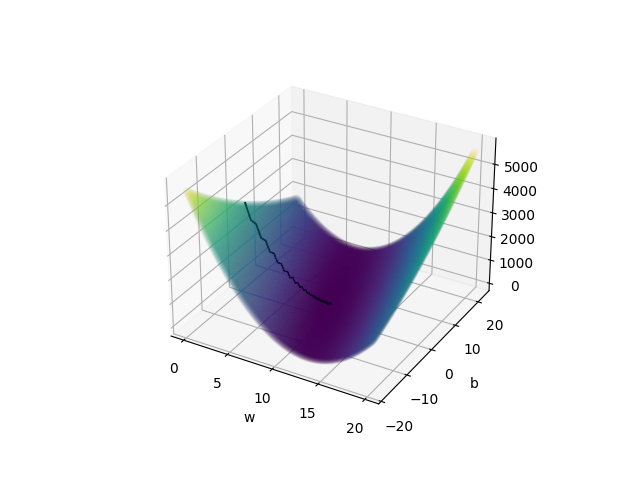

In [74]:
plt.close()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')

ax2.scatter(w_surface, b_surface, loss_surface, c = loss_surface, alpha = 0.02)
ax2.plot(w_array, b_array, loss_array, color='black')

ax2.set_xlabel('w')
ax2.set_ylabel('b')

plt.show()

## 结论

在这个任务中，我们学到了：

- 神经网络训练过程的基本组成部分
- 如何实现梯度下降优化器
- 梯度下降与随机梯度下降的区别及其对优化过程的影响
- 批量大小如何影响训练准确性

在本实验的下一部分中，我们将使用上面开发的代码并将其扩展到更大的神经网络，以便我们最终可以演示多 GPU 的实现。